In [184]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage import color
from skimage import io
from skimage.util import img_as_float
from skimage.util import img_as_ubyte

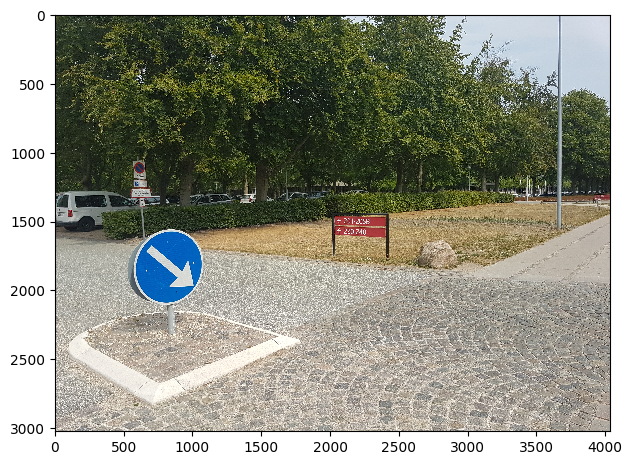

In [185]:
# Directory containing data and images
in_dir = "data/"
im_name = "vertebra.png"
im_vertebra = (io.imread(in_dir + im_name))
im_dark = img_as_ubyte(color.rgb2gray(io.imread(in_dir + 'dark_background.png')))
im_dtu = io.imread(in_dir + 'DTUSigns2.jpg')
io.imshow(im_dtu)

#### Exercise 1
Start by reading the image and inspect the histogram. Is it a bimodal histogram? Do you think it will be possible to segment it so only the bones are visible?

Yes the histogram is bimodal and it should be possible to segment bones and background

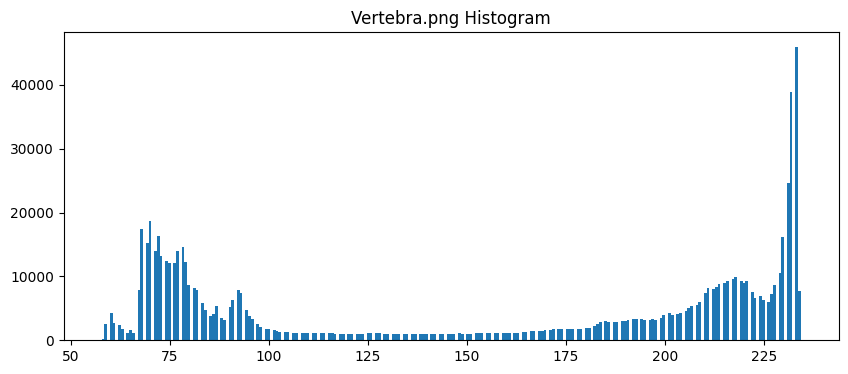

In [186]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))

ax.hist(im_vertebra.ravel(), bins=255)
ax.set_title('Vertebra.png Histogram')

io.show()

#### Exercise 2
Compute the minimum and maximum values of the image. Is the full scale of the gray-scale spectrum used or can we enhance the appearance of the image?

Minimum pixel value is 57 and the max value is 235, we should be able to enhance the image appearance by mapping pixel values to the full byte spectrum

In [187]:
min_vertebra = np.min(im_vertebra.ravel())
max_vertebra = np.max(im_vertebra.ravel())
min_vertebra, max_vertebra

(57, 235)

#### Exercise 4
Use img_as_ubyte on the float image you computed in the previous exercise. Compute the Compute the minimum and maximum values of this image. Are they as expected?

In [188]:
im_float = img_as_float(im_vertebra)
new_min = np.min(im_float.ravel())
new_max = np.max(im_float.ravel())
new_min, new_max

assert(np.min(img_as_ubyte(im_float)) == min_vertebra)
assert(np.max(img_as_ubyte(im_float)) == max_vertebra)

You should implement a function, that automatically stretches the histogram of an image. In other words, the function should create a new image, where the pixel values are changed so the histogram of the output image is optimal. Here optimal means, that the minimum value is 0 and the maximum value is 255. It should be based on the linear histogram stretching equation:

In [189]:
def hist_stretch_linear(img_in):
    im = img_as_float(img_in)
    min = im.min()
    max = im.max()
    offset = min
    gain = 1.0 / (max - min)
    im_stretch = gain * (im - offset)
    return img_as_ubyte(im_stretch)

In [1]:
im_stretch = hist_stretch_linear(im_vertebra)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))

ax0.hist(im_stretch.ravel(), bins=255)
ax0.set_title('Stretched Histogram')

ax1.imshow(im_vertebra, cmap='gray', vmin=0, vmax=255)
ax1.axis('off')
ax1.set_title('Before Stretching')

ax2.imshow(im_stretch, cmap='gray', vmin=0, vmax=255)
ax2.axis('off')
ax2.set_title('After Stretching')

io.show()

NameError: name 'hist_stretch_linear' is not defined

#### Exercise 7
Implement a function, gamma_map(img, gamma), that:

Converts the input image to float
Do the gamma mapping on the pixel values
Returns the resulting image as an unsigned byte image.

In [191]:
def gamma_map(img, gamma):
    im_float = img_as_float(img)
    im_power = np.power(im_float, gamma)
    return img_as_ubyte(im_power)

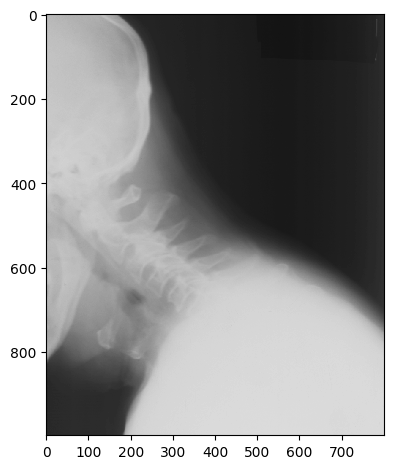

In [192]:
im0 = gamma_map(im_vertebra, 1.75)
io.imshow(im0)

Now we will try to implement some functions that can seperate an image into segments. In this exercise, we aim at seperating the background from the foreground by setting a threshold in a gray scale image or several thresholds in color images.

#### Exercise 9
Implement a function, threshold_image :

In [193]:
def threshold_image(img, thresh):
    bin = img > thresh
    return img_as_ubyte(bin)

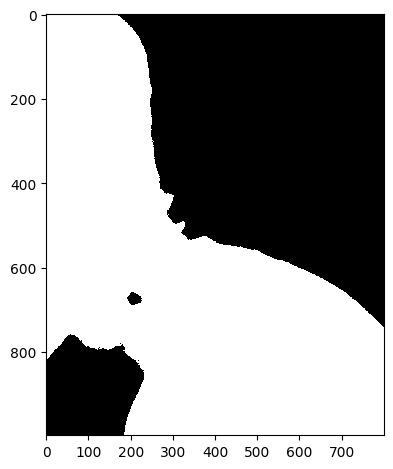

In [194]:
im_thresh = threshold_image(im_stretch, 150)
io.imshow(im_thresh)

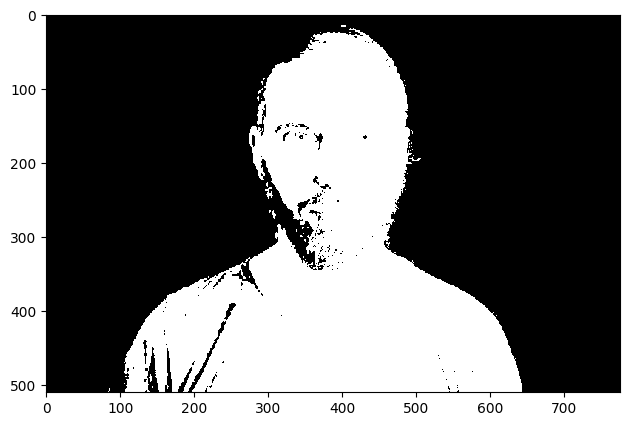

In [195]:
im0_thresh = threshold_image(im_dark, 10)
io.imshow(im0_thresh)

#### Exercise 10
Test your threshold_image function on the vertebra image with different thresholds. It is probably not possible to find a threshold that seperates the bones from the background, but can you find a threshold that seperates the human from the background?

The threshold to separate human from background is much more sensitive to changes as lighting is not uniform.

148


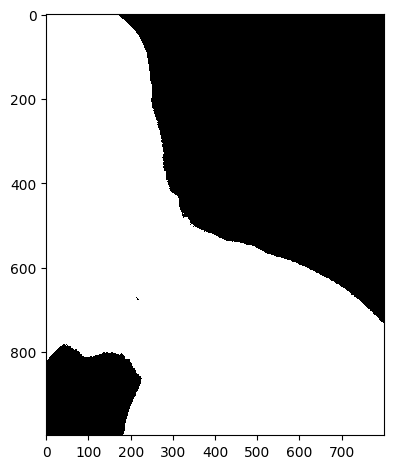

In [196]:
from skimage.filters import threshold_otsu
otsu = threshold_otsu(im_vertebra)
bin = img_as_ubyte(im_vertebra > otsu)
io.imshow(bin)
print(otsu)

## Color thresholding in the RGB color space

In the following, we will make a simple system for road-sign detection. Start by reading the image **DTUSigns2.jpg** found in the [exercise data](https://github.com/RasmusRPaulsen/DTUImageAnalysis/blob/main/exercises/ex3-PixelwiseOperations/data/). We want to make a system that do a *segmentation* of the image - meaning that a new binary image is created, where the foreground pixels correspond to the sign we want to detect.


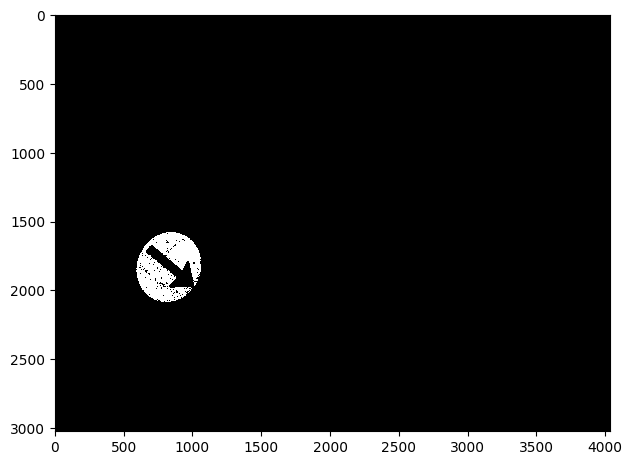

In [197]:
r_comp = im_dtu[:, :, 0]
g_comp = im_dtu[:, :, 1]
b_comp = im_dtu[:, :, 2]
segm_blue = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
            (b_comp > 180) & (b_comp < 200)

io.imshow(segm_blue)

In [198]:
def detect_dtu_signs(im, colour):
    r_comp = im[:, :, 0]
    g_comp = im[:, :, 1]
    b_comp = im[:, :, 2]

    if (colour == 0):
        segm = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
               (b_comp > 180) & (b_comp < 200)
    else:
        segm = (r_comp > 150) & \
               (g_comp < 80) & (g_comp > 10) &\
               (b_comp < 80) & (b_comp > 10)
    
    return img_as_ubyte(segm)

c:\Users\matth\anaconda3\envs\course02502\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


255

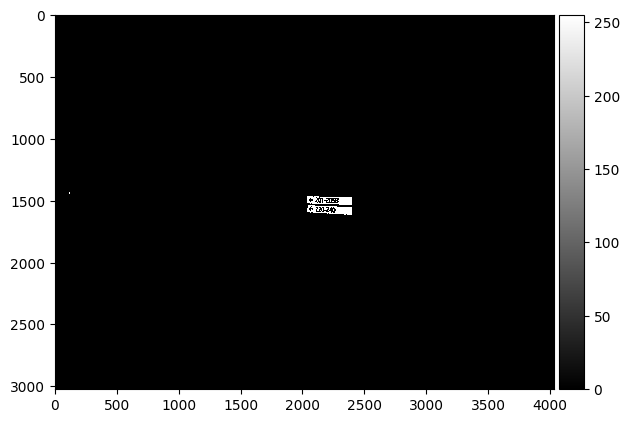

In [199]:
im_red = detect_dtu_signs(im_dtu, 1)
io.imshow(im_red, cmap='gray')
im_red.max()

## Color thresholding in the HSV color space

Sometimes it gives better segmentation results when the tresholding is done in HSI (also known as HSV - hue, saturation, value) space. Start by reading the  **DTUSigns2.jpg** image, convert it to HSV and show the hue and value (from [here](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_hsv.html)):

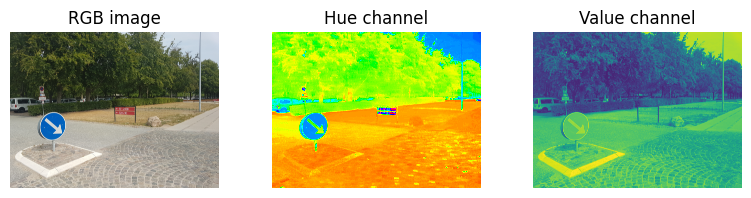

255

In [204]:
hsv_img = img_as_ubyte(color.rgb2hsv(im_dtu))
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))
ax0.imshow(im_dtu)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')
fig.tight_layout()
io.show()



In [296]:
def detect_signs_hsv(im, colour):
    im_hsv = img_as_ubyte(color.rgb2hsv(im))
    
    h_comp = im_hsv[:, :, 0]
    s_comp = im_hsv[:, :, 1]
    v_comp = im_hsv[:, :, 2]

    segm = (((h_comp >= 0) & (h_comp < 20)) | ((h_comp > 160) & (h_comp <= 255))) & \
           (s_comp > 150) & (v_comp > 150) 

    if (colour == 0):
        segm = ((h_comp >= 50) & (h_comp < 170)) & \
               (s_comp > 150) & (v_comp > 150) 
    else:
        segm = (((h_comp >= 0) & (h_comp < 20)) | ((h_comp > 160) & (h_comp <= 255))) & \
               (s_comp > 100) & (v_comp > 100) 


    return img_as_ubyte(segm)



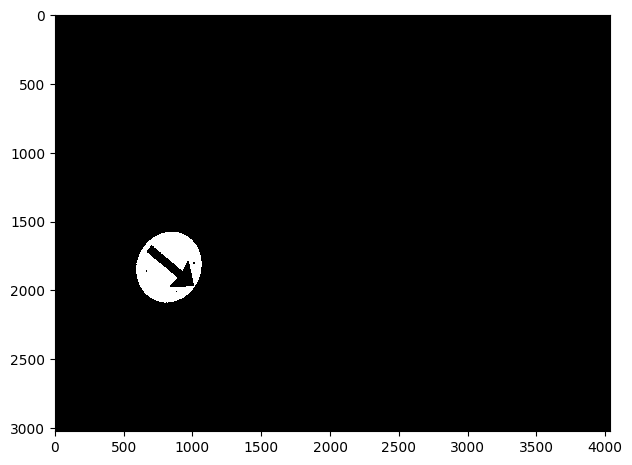

In [297]:
im_hsv_thresh = detect_signs_hsv(im_dtu, 0)
io.imshow(im_hsv_thresh)